In [1]:
import re
import scipy.io
from scipy import signal
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
directory = "C:\\Users\\grazi\\Desktop\\Materiale FVAB\\SEED_IV Database\\SEED_IV Database"
directory = "C:\\Users\\santo\\Downloads\\SEED_IV Database\\SEED_IV Database"
#directory = "D:\\DATASET FVAB\\SEED_IV Database\\SEED_IV Database\\"


In [3]:
directory

'C:\\Users\\santo\\Downloads\\SEED_IV Database\\SEED_IV Database'

# Original code

In [4]:
path = os.path.join(directory, "eeg_raw_data", "1", "10_20151014.mat")

In [5]:
data = scipy.io.loadmat(path)

In [6]:
#Prende tutti gli header per estrarre i dati
labels = list(data.keys())
size = len(labels)

In [7]:
# Carica il dataset in un dataframe di pandas usando gli header
for i in range(3,size,1):
    df = pd.DataFrame(data[labels[i]])
    print(df.shape)
    #df.transpose()
    #df.to_csv(labels[i]+".csv")

(62, 33601)
(62, 19001)
(62, 39801)
(62, 26001)
(62, 17601)
(62, 32401)
(62, 30601)
(62, 41801)
(62, 29001)
(62, 33801)
(62, 10001)
(62, 22001)
(62, 43401)
(62, 33801)
(62, 51801)
(62, 28201)
(62, 13601)
(62, 35801)
(62, 28001)
(62, 9601)
(62, 22401)
(62, 22401)
(62, 35001)
(62, 27401)


In [8]:
channel_order = pd.read_excel(os.path.join(directory,"Channel Order.xlsx"), engine="openpyxl",header=None)

In [9]:
session1_label = [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3]
session2_label = [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1]
session3_label = [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]
targets = session1_label + session2_label + session3_label

In [10]:
directory = os.path.join(directory, 'eeg_raw_data')

# Drop channels

In [11]:
def drop_channels(df):
    df = df.set_index(channel_order[0])
    df = df.transpose()
    df = df[['FT7','FT8','T7', 'T8', 'TP7', 'TP8']]
    df = df.transpose()
    return df

In [12]:
df_6_channels = drop_channels(pd.DataFrame(data['tyc_eeg1']))

In [13]:
df_6_channels.index.names = ['Channels']

In [14]:
print(df_6_channels.shape)

(6, 33601)


# Downsampling e filtering

In [15]:
def down_sampling(data):
    sfreq = 1000
    new_sfreq = 200
    
    data = signal.resample(data, int(len(data) * new_sfreq / sfreq))    
    return data

In [16]:
def band_pass_filter(data):
    sfreq = 1000
    nyquist_frequency = sfreq / 2
    lowcut = 0.3 
    highcut = 50
    order = 4
       
    b, a = signal.butter(order, [lowcut/nyquist_frequency, highcut/nyquist_frequency], btype='band')
    data = signal.filtfilt(b, a, data, padlen=0)
    return data

<AxesSubplot:>

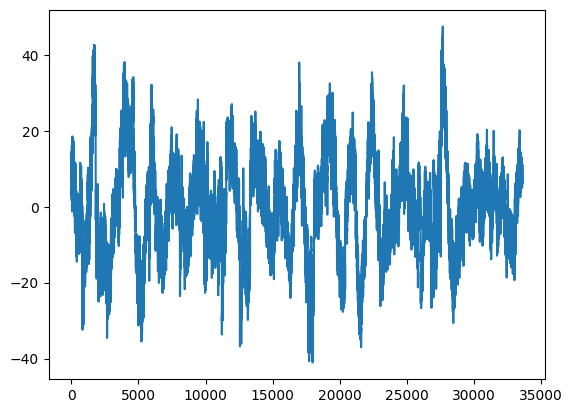

In [17]:
df_6_channels.iloc[3].plot()

In [18]:
processed_data_down = down_sampling(df_6_channels.T)

In [19]:
print(processed_data_down.shape)

(6720, 6)


<AxesSubplot:>

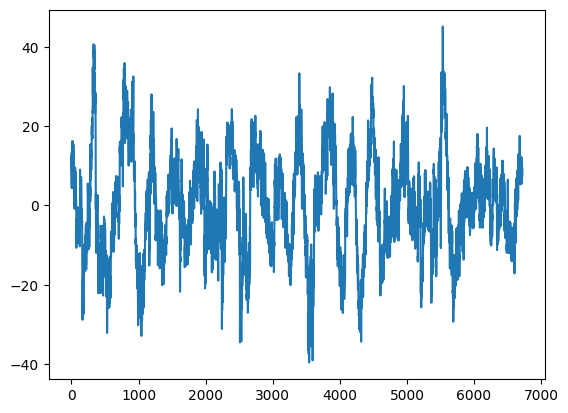

In [20]:
pd.DataFrame(processed_data_down)[3].plot()

In [21]:
processed_data_filter = band_pass_filter(processed_data_down)

In [22]:
print(processed_data_filter.shape)

(6720, 6)


<AxesSubplot:>

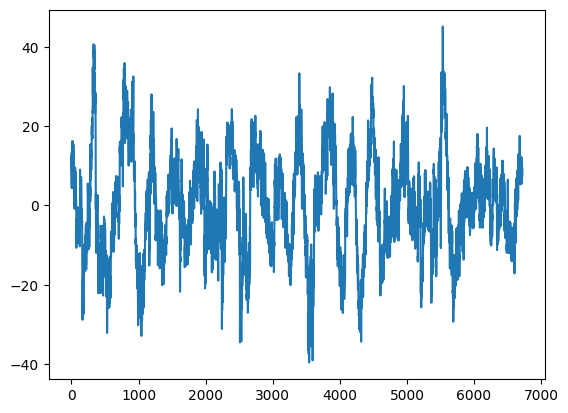

In [23]:
pd.DataFrame(processed_data_down)[3].plot()

In [24]:
filtered_dataset = pd.DataFrame(processed_data_filter).T

In [25]:
filtered_dataset['Channels'] = ['FT7','FT8','T7', 'T8', 'TP7', 'TP8']

In [26]:
filtered_dataset.set_index('Channels',inplace=True)

## Feature Extraction

### PSD

In [27]:
def psd_function(df):
    return signal.welch(df, 200 , noverlap=0, scaling="spectrum")

In [28]:
f, psd = psd_function(filtered_dataset)

In [29]:
psd.shape

(6, 129)

In [30]:
f.shape

(129,)

In [31]:
psd

array([[4.58629202e-04, 2.59448274e-03, 1.76812838e-03, 8.90338932e-04,
        7.71073861e-04, 4.38713160e-04, 2.06292724e-04, 1.85963791e-04,
        1.54299863e-04, 9.59339849e-05, 9.10601738e-05, 9.69510008e-05,
        8.92196375e-05, 7.44530637e-05, 6.25498420e-05, 4.18143750e-05,
        2.64341199e-05, 2.53899101e-05, 2.46435580e-05, 1.68642504e-05,
        2.44717278e-05, 2.64715214e-05, 1.83117699e-05, 1.81825260e-05,
        1.72619588e-05, 1.70779290e-05, 1.70015420e-05, 1.40976767e-05,
        1.16195006e-05, 1.21190278e-05, 8.52283163e-06, 8.87013450e-06,
        7.48162326e-06, 8.16390793e-06, 5.62941281e-06, 7.00792632e-06,
        9.73020740e-06, 6.85983341e-06, 4.86549382e-06, 4.40780090e-06,
        5.77111753e-06, 5.70927009e-06, 4.72801586e-06, 3.44136450e-06,
        3.54977307e-06, 4.61482178e-06, 4.21148847e-06, 3.74056367e-06,
        3.95950964e-06, 3.99572323e-06, 4.05226809e-06, 2.87947071e-06,
        1.89841966e-06, 2.01660146e-06, 2.73473403e-06, 3.312868

<AxesSubplot:>

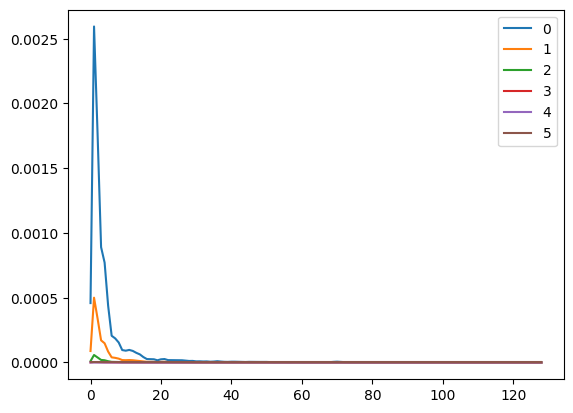

In [32]:
pd.DataFrame(psd.T).plot()

### DE

In [33]:
def de(df):
    return scipy.stats.differential_entropy(df)

In [34]:
entropy = de(psd)

In [35]:
entropy.shape

(129,)

<AxesSubplot:>

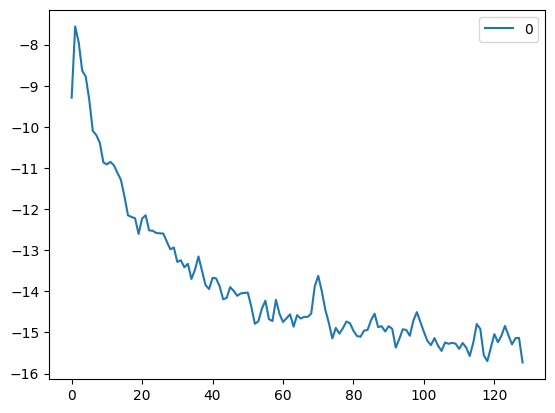

In [36]:
pd.DataFrame(entropy).plot()

### DASM

In [37]:
def dasm_function(psd):
    left_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[0,2,4]])
    right_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[1,3,5]])
    return np.abs(left_hemisphere_psd-right_hemisphere_psd)/(left_hemisphere_psd+right_hemisphere_psd)

In [38]:
dasm = dasm_function(psd)

In [39]:
dasm.shape

(3, 129)

<AxesSubplot:>

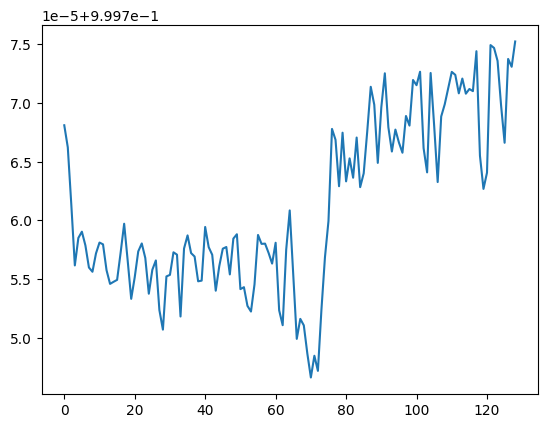

In [40]:
pd.DataFrame(dasm).iloc[2].plot()

### ASM

In [41]:
def asm_function(psd):
    left_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[0,2,4]])
    right_hemisphere_psd = np.array(pd.DataFrame(psd).iloc[[1,3,5]])
    return (np.sum(left_hemisphere_psd, axis=0) - np.sum(right_hemisphere_psd, axis=0)) / np.sum(left_hemisphere_psd + right_hemisphere_psd, axis=0)

In [42]:
asm = asm_function(psd)

In [43]:
asm.shape

(129,)

<AxesSubplot:>

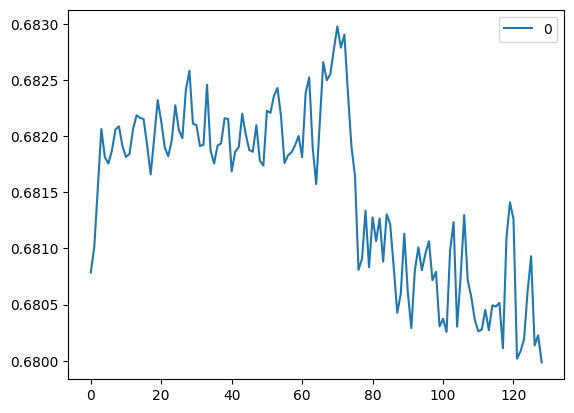

In [44]:
pd.DataFrame(asm).plot()

# Script Feature Extraction

In [68]:
def feature_extraction(df):
    #calcolo psd + de + dasm + asm
    f, psd = psd_function(filtered_dataset)
    entropy = de(psd)
    dasm = dasm_function(psd)
    asm = asm_function(psd)
    #combinazione risultati psd + de + dasm + asm (approccio che fa esplodere la dimensionalità del dataset)
    return np.concatenate((psd.flatten(),entropy,dasm.flatten(),asm)) 

In [69]:
result = feature_extraction(filtered_dataset)

In [70]:
result.shape

(2193,)

In [48]:
df = pd.DataFrame(result).T 

In [49]:
df['file'] = ['mat123432'] #placeholder temporaneo (aggiungere anche identificativo utente nella chiave)

In [50]:
df['id'] = labels[0]

In [51]:
df['label'] = targets[0]

In [52]:
df.set_index(['file','id'], inplace=True)

In [53]:
df

,,0,1,2,3,4,5,6,7,8,9,...,8001,8002,8003,8004,8005,8006,8007,8008,8009,label
file,id,,,,,,,,,,,,,,,,,,,,,
mat123432,__header__,0.000459,0.002594,0.001768,0.00089,0.000771,0.000439,0.000206,0.000186,0.000154,0.000096,...,0.681261,0.680017,0.680084,0.680192,0.680615,0.68093,0.680136,0.680227,0.679984,1


# Concatenazione

In [54]:
df_global = pd.DataFrame()

In [55]:
pd.concat([df_global,df])

,,0,1,2,3,4,5,6,7,8,9,...,8001,8002,8003,8004,8005,8006,8007,8008,8009,label
file,id,,,,,,,,,,,,,,,,,,,,,
mat123432,__header__,0.000459,0.002594,0.001768,0.00089,0.000771,0.000439,0.000206,0.000186,0.000154,0.000096,...,0.681261,0.680017,0.680084,0.680192,0.680615,0.68093,0.680136,0.680227,0.679984,1


In [78]:
result.shape[0]

2193

In [57]:
#print(os.getcwd())
resDF = pd.DataFrame(result).T
resDF.to_csv("10_20151014.csv")
resDF.head()

,0,1,2,3,4,5,6,7,8,9,...,8000,8001,8002,8003,8004,8005,8006,8007,8008,8009
0,0.000459,0.002594,0.001768,0.00089,0.000771,0.000439,0.000206,0.000186,0.000154,0.000096,...,0.681411,0.681261,0.680017,0.680084,0.680192,0.680615,0.68093,0.680136,0.680227,0.679984


# Script

In [80]:
df_global = pd.DataFrame()
if os.path.exists(directory):
    lista_cartella_main = os.listdir(directory)
    #For che Scansiona le cartelle delle sessioni
    for file in lista_cartella_main:
        sec = os.path.join(directory, file)
        if os.path.isdir(sec):
            session = int(sec[-1])
            files1 = os.listdir(sec)
            #For che Scansiona i file .Mat nelle cartelle sessioni
            for file1 in files1:
                j = 24 * (int(session) - 1)
                if file1.endswith(".mat"):
                    file1 = os.path.join(sec, file1)
                    data = scipy.io.loadmat(file1)
                    labels = list(data.keys())
                    size = len(labels)
                    print("file1",file1)
                    maximum = 0
                    for i in range(3,size,1):
                        id_user = labels[i]
                        df = pd.DataFrame(data[id_user])
                        df = drop_channels(df)
                        downsampled = down_sampling(data[labels[i]])
                        filtered = band_pass_filter(downsampled)
                        filtered_dataset = pd.DataFrame(filtered)
                        result = feature_extraction(filtered_dataset)
                        print("shape result",result.shape)
                        
                        #Label colonne df finale
                        id_person = re.findall("\d+_", file1)
                        id_person = re.findall("\d+", id_person[0])
                        video = re.findall("\d+", labels[i])
                        target = targets[j]
                        j += 1

                        df_tmp = pd.DataFrame(result).T
                        df_tmp['id_user'] = id_person
                        df_tmp['session'] = session
                        df_tmp['video'] = video
                        df_tmp['emotion'] = target
                        #print(df_tmp.head())
                        print("shape tmp",df_tmp.shape)
                        df_global = pd.concat([df_global,df_tmp])
                        print("shape df",df_global.shape)
                        

file1 C:\Users\santo\Downloads\SEED_IV Database\SEED_IV Database\eeg_raw_data\1\10_20151014.mat
shape result (2193,)
shape tmp (1, 2197)
shape df (1, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (2, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (3, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (4, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (5, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (6, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (7, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (8, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (9, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (10, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (11, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (12, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (13, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (14, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (15, 2197

shape result (2193,)
shape tmp (1, 2197)
shape df (127, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (128, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (129, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (130, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (131, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (132, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (133, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (134, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (135, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (136, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (137, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (138, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (139, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (140, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (141, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (142, 2197)
shape re

shape result (2193,)
shape tmp (1, 2197)
shape df (254, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (255, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (256, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (257, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (258, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (259, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (260, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (261, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (262, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (263, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (264, 2197)
file1 C:\Users\santo\Downloads\SEED_IV Database\SEED_IV Database\eeg_raw_data\1\6_20150507.mat
shape result (2193,)
shape tmp (1, 2197)
shape df (265, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (266, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (267, 2197)
shape result (2193,)
shape tmp (1, 21

shape result (2193,)
shape tmp (1, 2197)
shape df (381, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (382, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (383, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (384, 2197)
file1 C:\Users\santo\Downloads\SEED_IV Database\SEED_IV Database\eeg_raw_data\2\11_20150921.mat
shape result (2193,)
shape tmp (1, 2197)
shape df (385, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (386, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (387, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (388, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (389, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (390, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (391, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (392, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (393, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (394, 2197)
shape result (2193,)
shape tmp (1, 2

shape result (2193,)
shape tmp (1, 2197)
shape df (508, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (509, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (510, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (511, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (512, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (513, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (514, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (515, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (516, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (517, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (518, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (519, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (520, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (521, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (522, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (523, 2197)
shape re

shape result (2193,)
shape tmp (1, 2197)
shape df (633, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (634, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (635, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (636, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (637, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (638, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (639, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (640, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (641, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (642, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (643, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (644, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (645, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (646, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (647, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (648, 2197)
file1 C:

shape result (2193,)
shape tmp (1, 2197)
shape df (759, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (760, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (761, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (762, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (763, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (764, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (765, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (766, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (767, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (768, 2197)
file1 C:\Users\santo\Downloads\SEED_IV Database\SEED_IV Database\eeg_raw_data\3\12_20150807.mat
shape result (2193,)
shape tmp (1, 2197)
shape df (769, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (770, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (771, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (772, 2197)
shape result (2193,)
shape tmp (1, 2

shape df (886, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (887, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (888, 2197)
file1 C:\Users\santo\Downloads\SEED_IV Database\SEED_IV Database\eeg_raw_data\3\2_20151012.mat
shape result (2193,)
shape tmp (1, 2197)
shape df (889, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (890, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (891, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (892, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (893, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (894, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (895, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (896, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (897, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (898, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (899, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (900, 2197)
shape result (21

shape result (2193,)
shape tmp (1, 2197)
shape df (1012, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1013, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1014, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1015, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1016, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1017, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1018, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1019, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1020, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1021, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1022, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1023, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1024, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1025, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1026, 2197)
shape result (2193,)
shape tmp (1, 2197)
shape df (1027

In [81]:
df_global.head()

,0,1,2,3,4,5,6,7,8,9,...,2187,2188,2189,2190,2191,2192,id_user,session,video,emotion
0,6.583541,37.277407,28.529193,14.189524,10.570123,7.065753,4.172613,2.582892,1.943556,1.398289,...,-0.072812,-0.064210,-0.051303,-0.033039,-0.012590,-0.002463,10,1,1,1
0,23998.749435,316887.068421,87736.804394,23383.566126,7296.191907,4125.860920,1963.987642,1165.630551,716.861729,406.881850,...,-0.300791,-0.300789,-0.300786,-0.300776,-0.300724,-0.295641,10,1,2,2
0,4.570119,19.422401,11.774605,6.061812,4.072680,3.133726,2.289930,1.478156,1.104940,0.945963,...,0.019878,0.016531,0.011302,0.003434,-0.006106,-0.011147,10,1,3,3
0,5.721610,24.103623,14.597546,8.093111,5.460191,4.099399,2.897292,2.011409,1.666509,1.265870,...,0.132360,0.137096,0.144212,0.154304,0.165636,0.171262,10,1,4,0
0,6.288494,28.585425,23.250418,12.565008,7.561715,4.817271,2.905645,1.797679,1.047151,0.886269,...,0.093364,0.090145,0.085718,0.080160,0.074745,0.072329,10,1,5,2


In [86]:
df_global.tail()

,0,1,2,3,4,5,6,7,8,9,...,2187,2188,2189,2190,2191,2192,id_user,session,video,emotion
0,11.290045,54.206569,58.843308,36.166094,18.545053,9.263528,5.302937,3.551326,2.519682,1.623845,...,-0.321762,-0.319976,-0.316967,-0.311862,-0.304527,-0.300016,9,3,20,0
0,6.812914,35.630436,45.557098,29.202574,13.633124,7.481116,4.559911,3.021838,1.820840,1.341524,...,-0.369973,-0.351161,-0.322081,-0.279063,-0.228091,-0.201670,9,3,21,2
0,7.295943,33.682035,30.651121,21.858692,11.198493,5.659393,3.396850,2.462939,1.881133,1.342644,...,-0.254811,-0.239297,-0.218129,-0.191821,-0.166482,-0.155270,9,3,22,0
0,10.740729,52.917941,46.746511,30.375687,14.796748,7.259648,4.166853,3.125561,1.978342,1.264072,...,-0.282763,-0.271689,-0.254571,-0.229255,-0.199262,-0.183718,9,3,23,1
0,9.046757,50.292294,43.331499,27.499900,14.877158,8.385505,4.700691,3.377040,2.803946,1.705286,...,-0.350380,-0.339892,-0.323018,-0.296462,-0.262248,-0.243207,9,3,24,0


In [84]:
df_global.describe()

,0,1,2,3,4,5,6,7,8,9,...,2185,2186,2187,2188,2189,2190,2191,2192,session,emotion
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,438.090394,947.885928,295.212488,165.962137,147.692119,100.313171,63.269174,45.255394,31.545106,24.616980,...,0.154146,0.156723,0.160443,0.165933,0.174057,0.185297,0.196544,0.199128,2.000000,1.500000
std,11684.035393,14423.225891,3018.069718,1308.547346,1357.115602,883.486951,609.858852,449.166202,324.577015,285.186728,...,0.204899,0.202247,0.198482,0.193044,0.185220,0.174679,0.163482,0.157435,0.816875,1.118552
min,0.942930,5.219086,3.158922,1.356068,0.713645,0.715570,0.720091,0.611991,0.579468,0.397995,...,-0.693506,-0.692787,-0.691599,-0.689427,-0.684803,-0.672106,-0.614457,-0.405550,1.000000,0.000000
25%,6.434571,35.687531,26.142505,15.521025,10.054344,6.332905,4.383764,3.159292,2.552963,2.024779,...,0.030368,0.037532,0.044747,0.058904,0.075783,0.095227,0.115816,0.118120,1.000000,0.750000
50%,12.783128,72.190027,53.266044,30.642139,18.577915,11.610577,7.550633,5.258333,4.127177,3.226610,...,0.130159,0.135366,0.141460,0.145300,0.156006,0.171000,0.185759,0.195180,2.000000,1.500000
75%,25.669109,148.558925,112.939201,72.962198,47.273156,28.532731,17.984014,12.061897,8.151579,5.835155,...,0.247918,0.246509,0.244196,0.245258,0.249015,0.255021,0.274087,0.281435,3.000000,2.250000
max,382949.739866,345326.246304,87736.804394,23383.566126,34814.105733,20922.368338,13147.333533,8609.663366,7967.544540,7794.077948,...,0.911181,0.909625,0.907077,0.902490,0.893024,0.868917,0.785496,0.756560,3.000000,3.000000


In [85]:
df_global.columns

Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,
       ...
            2187,      2188,      2189,      2190,      2191,      2192,
       'id_user', 'session',   'video', 'emotion'],
      dtype='object', length=2197)

In [87]:
df_global.to_csv('dataset_eeg.csv')